In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
import numpy as np
import math
import pandas as pd
from collections import Counter
import numpy as np
import pickle
import unicodedata

In [ ]:
nltk.download('stopwords')
nltk.download('punkt_tab')
Stopwords = set(stopwords.words('english'))
ps=PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
def remove_special_characters(text):
    regex = re.compile('[^a-zA-Z\s]')
    text_returned = re.sub(regex,' ',text)
    return text_returned
def strip_accents(text):
    return ''.join(c for c in unicodedata.normalize('NFKD', text) if unicodedata.category(c) != 'Mn')

In [ ]:
data = pd.read_csv('/content/English.csv')

In [ ]:
with open('pickles/df.pkl','rb') as file:
    DF=pickle.load(file)
    file.close()

with open('pickles/file_idx.pkl','rb') as file:
    file_idx=pickle.load(file)
    file.close()

with open('pickles/doc_words.pkl','rb') as file:
    doc_words=pickle.load(file)
    file.close()

with open('pickles/doc_norm.pkl','rb') as file:
    doc_norm=pickle.load(file)
    file.close()

with open('pickles/posting_list.pkl','rb') as file:
    tf=pickle.load(file)
    file.close()

with open('pickles/doc_len.pkl','rb') as file:
    doc_len=pickle.load(file)
    file.close()

##TFIDF

In [ ]:
def tfidf(query,counter=10):
    query=strip_accents(query)
    text = remove_special_characters(query)
    text = re.sub(re.compile('\d'),'',text)
    words = word_tokenize(text)
    words = [word.lower() for word in words]
    words=[ps.stem(word) for word in words]
    words=[word for word in words if word not in Stopwords]
    words=[word for word in words if word in DF.keys()]

    q=[]
    q_norm=0
    for w in words:
        tf_idf=(words.count(w)*math.log(len(file_idx)/DF[w]))
        q.append(tf_idf)
        q_norm+=tf_idf**2
    q_norm=math.sqrt(q_norm)

    q=np.array(q)/q_norm

    score={}

    for i in range(len(file_idx)):
        doc_v=[]
        for w in words:
            tf_idf=(doc_words[i].count(w)*math.log(len(file_idx)/DF[w]))
            doc_v.append(tf_idf)
        doc_v=np.array(doc_v)/doc_norm[i]
        score[i]=np.dot(q,doc_v)

    score=sorted(score.items(),key=lambda x:x[1],reverse=True)
    verse_index=[]
    for i in score:
        if counter== 0:
            break
        verse_index.append(i[0])
        counter-=1
    return verse_index

In [ ]:
verse_index=tfidf('bhagavad gita importance')
data.loc[verse_index]

,Chapter,Verse,Sloke,Commentary
587,18,68,य इदं परमं गुह्यं मद्भ‍क्तेष्वभिधास्यति ।भक्ति...,Generally it is advised that Bhagavad-gītā be ...
183,4,42,तस्मादज्ञानसम्भूतं हृत्स्थं ज्ञानासिनात्मनः ।छ...,The yoga system instructed in this chapter is ...
586,18,67,इदं ते नातपस्काय नाभक्ताय कदाचन ।न चाश‍ुश्रूषव...,Persons who have not undergone the austerities...
40,2,11,श्री भगवानुवाचअशोच्यनन्वशोचस्त्वं प्रज्ञावादां...,The Lord at once took the position of the teac...
303,8,28,वेदेषु यज्ञेषु तप:सु चैवदानेषु यत्पुण्यफलं प्र...,This verse is the summation of the Seventh and...
589,18,72,कच्च‍िदेतच्छ्रुतं पार्थ त्वयैकाग्रेण चेतसा ।कच...,The Lord was acting as the spiritual master of...
472,14,21,अर्जुन उवाचकैर्लिङ्गैस्त्रीन्गुणानेतानतीतो भवत...,"In this verse, Arjuna’s questions are very app..."
283,8,7,तस्मात्सर्वेषु कालेषु मामनुस्मर युध्य च ।मय्यर...,This instruction to Arjuna is very important f...
371,10,38,दण्डो दमयतामस्मि नीतिरस्मि जिगीषताम् ।मौनं चैव...,"There are many suppressing agents, of which th..."
347,10,14,सर्वमेतदृतं मन्ये यन्मां वदसि केशव ।न हि ते भग...,Arjuna herein confirms that persons of faithle...



##bm25


In [ ]:
k=0
Ld=doc_len
N=len(file_idx)
for i in Ld:
    k+=Ld[i]
Lavg=k/N

In [ ]:
def IDF(q):
    DF1=0
    if q in DF:
        DF1=DF[q]
    ans=math.log((N-DF1+0.5)/(DF1+0.5))
    return ans
k=1.2
b=0.75

In [ ]:
def bm25(query,counter=10):
    query=strip_accents(query)
    score={}
    for i in range(len(file_idx)):
        score[i]=0
    q = remove_special_characters(query)
    words = word_tokenize(q)
    words = [word.lower() for word in words]
    words=[ps.stem(word) for word in words]
    words=[word for word in words if word not in Stopwords]
    for i in range(len(file_idx)):
        score[i]=0
        for qi in words:
            TF=0
            if qi in tf:
                if i in tf[qi]:
                    TF=tf[qi][i]
            idf=IDF(qi)
            ans=idf*(k+1)*TF/(TF+k*(1-b+b*(Ld[i]/Lavg)))
            score[i]+=ans
    score=sorted(score.items(),key=lambda item: item[1],reverse=True)
    verse_index=[]
    for i in score:
        if counter== 0:
            break
        verse_index.append(i[0])
        counter-=1
    return verse_index

In [ ]:
verse_index=bm25('importance of bhagavad gita')
data.loc[verse_index]

,Chapter,Verse,Sloke,Commentary
183,4,42,तस्मादज्ञानसम्भूतं हृत्स्थं ज्ञानासिनात्मनः ।छ...,The yoga system instructed in this chapter is ...
81,2,54,अर्जुन उवाचस्थितप्रज्ञस्य का भाषा समाधिस्थस्य ...,"As there are symptoms for each and every man, ..."
583,18,64,सर्वगुह्यतमं भूय: श‍ृणु मे परमं वच: ।इष्टोऽसि ...,The Lord has given Arjuna knowledge that is co...
591,18,74,इत्यहं वासुदेवस्य पार्थस्य च महात्मन: ।संवादमि...,"In the beginning of Bhagavad-gītā, Dhṛtarāṣṭra..."
410,11,52,श्रीभगवानुवाचसुदुर्दर्शमिदं रूपं दृष्टवानसि यन...,In the forty-eighth verse of this chapter Lord...
0,1,1,धृतराष्ट्र उवाचधर्मक्षेत्रे कुरुक्षेत्रे समवेत...,Bhagavad-gītā is the widely read theistic scie...
306,9,3,अश्रद्दधाना: पुरुषा धर्मस्यास्य परन्तप ।अप्राप...,The faithless cannot accomplish this process o...
184,5,1,अर्जुन उवाचसन्न्यासं कर्मणां कृष्ण पुनर्योगं च...,"In this Fifth Chapter of the Bhagavad-gītā, th..."
41,2,12,न त्वेवाहं जातु नासं न त्वं नेमे जनाधिपाः ।न च...,In the Vedas – in the Kaṭha Upaniṣad as well a...
371,10,38,दण्डो दमयतामस्मि नीतिरस्मि जिगीषताम् ।मौनं चैव...,"There are many suppressing agents, of which th..."


## LSA

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

docs = data['Commentary'].astype(str).tolist()

tfidf = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2),       # include both 1-word and 2-word tokens
    min_df=2,                 # ignore tokens in fewer than 2 docs
    stop_words='english',     # still drop common English stopwords
    token_pattern=r'\b\w+\b'  # keep only alphanumeric tokens
)

X = tfidf.fit_transform(docs)

# 2) Run LSA
lsa = TruncatedSVD(n_components=15, random_state=42)
X_lsa = lsa.fit_transform(X)

data['LSA_Cluster'] = KMeans(n_clusters=5, random_state=42).fit_predict(X_lsa)

# 3) Inspect cleaned-up topics
terms = tfidf.get_feature_names_out()
for i, comp in enumerate(lsa.components_):
    tops = comp.argsort()[-10:][::-1]
    print(f"Topic {i+1}: " + ", ".join(terms[j] for j in tops))


Topic 1: kṛṣṇa, lord, supreme, material, consciousness, kṛṣṇa consciousness, living, service, knowledge, personality
Topic 2: kṛṣṇa, hare, kṛṣṇa consciousness, service, devotee, consciousness, rāma, yoga, devotional, devotional service
Topic 3: mode, consciousness, kṛṣṇa consciousness, goodness, sense, work, passion, mode goodness, ignorance, mode passion
Topic 4: hare, rāma, mode, hare hare, hare kṛṣṇa, kṛṣṇa hare, rāma hare, hare rāma, rāma rāma, goodness
Topic 5: mode, arjuna, form, goodness, ignorance, universal form, universal, passion, mode goodness, mode ignorance
Topic 6: hare, arjuna, kṛṣṇa, body, rāma, soul, hare hare, form, hare kṛṣṇa, universal form
Topic 7: soul, body, individual, knowledge, individual soul, mode, gītā, devotional, spirit, atomic
Topic 8: mind, lord, senses, sense, devotee, yoga, demigods, engaged, form, supreme lord
Topic 9: kṛṣṇa, mode, supreme, soul, personality, personality godhead, supreme personality, consciousness, godhead, person
Topic 10: service,

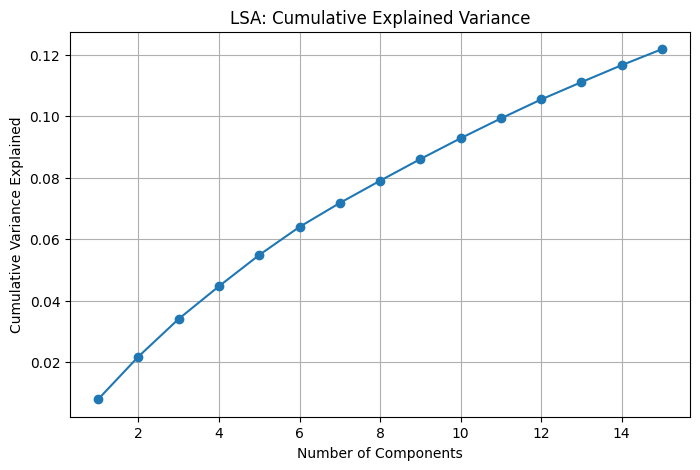

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(lsa.explained_variance_ratio_)+1),
         lsa.explained_variance_ratio_.cumsum(), marker='o')
plt.title("LSA: Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X_lsa)

# Add cluster labels to your DataFrame
data['LSA_Cluster'] = clusters

# Evaluate clustering
score = silhouette_score(X_lsa, clusters)
print(f"Silhouette Score (LSA + KMeans, {num_clusters} clusters): {score:.3f}")

Silhouette Score (LSA + KMeans, 5 clusters): 0.113


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity



docs = data['Commentary'].astype(str).tolist()

def retrieve(query, k=5):
    # vectorize query
    q_tfidf = tfidf.transform([query])
    q_lsa   = lsa.transform(q_tfidf)
    # compute similarities
    sim_tfidf = cosine_similarity(X, q_tfidf).ravel()
    sim_lsa   = cosine_similarity(X_lsa, q_lsa).ravel()
    # get top-k doc indices
    top_tfidf = np.argsort(sim_tfidf)[-k:][::-1]
    top_lsa   = np.argsort(sim_lsa)[-k:][::-1]
    return top_tfidf, top_lsa

# Example
q = "krishna consciousness"
tfidf_hits, lsa_hits = retrieve(q)
print("TF–IDF   top docs:", tfidf_hits)
print("LSA      top docs:", lsa_hits)


TF–IDF   top docs: [450 481 165 156  70]
LSA      top docs: [541 116 123  69 577]


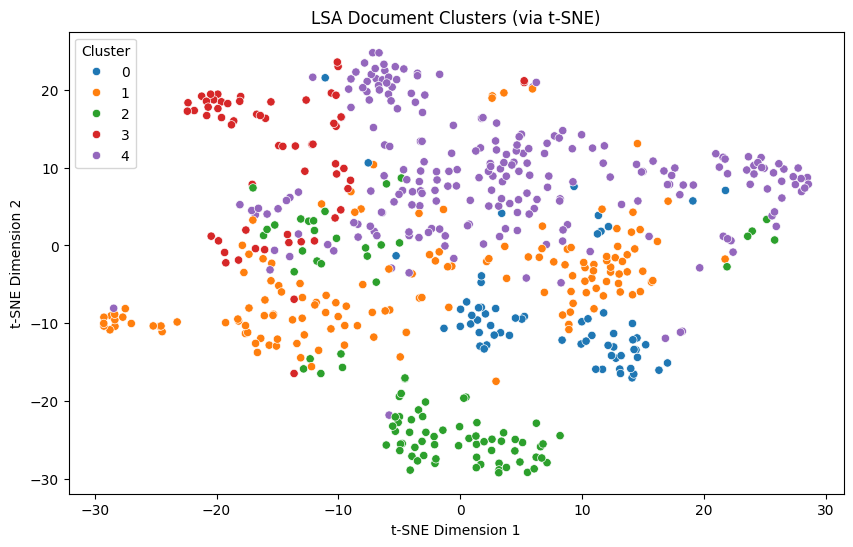

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(X_lsa)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=data['LSA_Cluster'], palette='tab10')
plt.title("LSA Document Clusters (via t-SNE)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster")
plt.show()


# Cluster 0 (Blue): verses about knowledge
# Cluster 1 (Orange): verses around detachment, renunciation, or duties
# Cluster 2 (Green): verses around spiritual devotion
# Cluster 3 (Red): verses around warfare, leadership, dharma
# Cluster 4 (Purple): verses around on life/death cycles, soul, rebirth

In [ ]:
for cluster in range(num_clusters):
    print(f"\nCluster {cluster}:")
    print(data[data['LSA_Cluster'] == cluster]['Verse'].head(5))



Cluster 0:
68    39
71    44
75    48
83    56
85    58
Name: Verse, dtype: int64

Cluster 1:
37     8
69    40
70    41
76    49
78    51
Name: Verse, dtype: int64

Cluster 2:
40    11
41    12
42    13
45    16
46    17
Name: Verse, dtype: int64

Cluster 3:
14     24
15     25
31      2
32      3
144     3
Name: Verse, dtype: int64

Cluster 4:
0    1
1    2
2    3
3    4
4    8
Name: Verse, dtype: int64


In [ ]:
terms = tfidf.get_feature_names_out()
for i, comp in enumerate(lsa.components_):
    tops = comp.argsort()[-10:][::-1]
    print(f"Topic {i+1}: " + ", ".join(terms[j] for j in tops))
topic_names = {}

terms = tfidf.get_feature_names_out()
for i, comp in enumerate(lsa.components_):
    top_terms = [terms[j] for j in comp.argsort()[-5:][::-1]]  # Top 5 terms
    topic_name = " / ".join(top_terms)
    topic_names[f"Topic_{i+1}"] = topic_name
    print(f"Topic {i+1}: {topic_name}")


Topic 1: kṛṣṇa, lord, supreme, material, consciousness, kṛṣṇa consciousness, living, service, knowledge, personality
Topic 2: kṛṣṇa, hare, kṛṣṇa consciousness, service, devotee, consciousness, rāma, yoga, devotional, devotional service
Topic 3: mode, consciousness, kṛṣṇa consciousness, goodness, sense, work, passion, mode goodness, ignorance, mode passion
Topic 4: hare, rāma, mode, hare hare, hare kṛṣṇa, kṛṣṇa hare, rāma hare, hare rāma, rāma rāma, goodness
Topic 5: mode, arjuna, form, goodness, ignorance, universal form, universal, passion, mode goodness, mode ignorance
Topic 6: hare, arjuna, kṛṣṇa, body, rāma, soul, hare hare, form, hare kṛṣṇa, universal form
Topic 7: soul, body, individual, knowledge, individual soul, mode, gītā, devotional, spirit, atomic
Topic 8: mind, lord, senses, sense, devotee, yoga, demigods, engaged, form, supreme lord
Topic 9: kṛṣṇa, mode, supreme, soul, personality, personality godhead, supreme personality, consciousness, godhead, person
Topic 10: service,

## LSA + Topic modelling


In [ ]:
import numpy as np

terms      = tfidf.get_feature_names_out()
components = lsa.components_

for cluster in sorted(data['LSA_Cluster'].unique()):
    mask = data['LSA_Cluster'] == cluster
    centroid = X_lsa[mask].mean(axis=0)
    term_weights = centroid.dot(components)

    # pick top 10 terms, but drop duplicates if any
    idxs = np.argsort(term_weights)[-20:][::-1]  # look at top 20
    seen, top_terms = set(), []
    for i in idxs:
        t = terms[i]
        if t not in seen:
            seen.add(t)
            top_terms.append(t)
        if len(top_terms) == 10:
            break

    print(f"\nCluster {cluster} — Top terms:")
    print(", ".join(top_terms))
    print("some verses in this cluster:")
    for text in data.loc[mask, 'Sloke'].head(5):
        print(" •", text)



Cluster 0 — Top terms:
yoga, mind, kṛṣṇa, senses, consciousness, kṛṣṇa consciousness, sense, practice, lord, service
Example verses in this cluster:
 • एषा तेऽभिहिता सांख्ये बुद्धिर्योगे त्विमां श‍ृणु ।बुद्ध्या युक्तो यया पार्थ कर्मबन्धं प्रहास्यसि ॥ ३९ ॥
 • भोगैश्वर्यप्रसक्तानां तयापहृतचेतसाम् ।व्यवसायात्मिका बुद्धिः समाधौ न विधीयते ॥ ४४ ॥
 • योगस्थः कुरु कर्माणि सङ्गं त्यक्त्वा धनञ्जय ।सिद्ध्यसिद्ध्योः समो भूत्वा समत्वं योग उच्यते ॥ ४८ ॥
 • दुःखेष्वनुद्विग्न‍मनाः सुखेषु विगतस्पृहः ।वीतरागभयक्रोधः स्थिधीर्मुनिरुच्यते ॥ ५६ ॥
 • यदा संहरते चायं कूर्मोऽङ्गानीव सर्वशः ।इन्द्रियाणीन्द्रियार्थेभ्यस्तस्य प्रज्ञा प्रतिष्ठिता ॥ ५८ ॥

Cluster 1 — Top terms:
kṛṣṇa, consciousness, lord, kṛṣṇa consciousness, service, supreme, devotional, hare, devotional service, devotee
Example verses in this cluster:
 • न हि प्रपश्यामि ममापनुद्याद् -यच्छोकमुच्छोषणमिन्द्रियाणाम् ।अवाप्य भूभावसपत्‍नमृद्धंराज्यं सुराणामपि चाधिपत्यम् ॥ ८ ॥
 • नेहाभिक्रमनाशोऽस्ति प्रत्यवायो न विद्यते ।स्वल्पमप्यस्य धर्मस्य त्रायते म